In [1]:
generating_class = 'TUG'
real_dir = 'DATASET54000'
fake_dir = 'VAE-F64'

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
import optuna
import gc
from keras import ops
from keras import layers
from tqdm import tqdm
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt


from skimage.metrics import structural_similarity as ssim
from torchvision import transforms
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance
from itertools import product
import torch
import torchvision


print(f"Versão do Tensorflow: {tf.__version__}")
devices = tf.config.list_physical_devices('GPU')
if devices:
    print(f"GPU disponivel: {devices}")
    print(f"Número de GPUs: {len(devices)}")
else:
    print("GPU não está disponível. Usando CPU")

print(f"PyTorch version: {torch.__version__}")
print(torchvision.__version__)
print(torch.cuda.is_available())  # Deve retornar True se a GPU estiver configurada corretamente
print(torch.cuda.get_device_name(0))  # Nome da GPU

2025-07-25 02:58:22.748458: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 02:58:22.769478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Versão do Tensorflow: 2.16.1
GPU disponivel: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Número de GPUs: 1
PyTorch version: 2.0.1+cu118
0.15.2+cu118
True
NVIDIA GeForce RTX 4090


2025-07-25 02:58:24.523749: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 02:58:24.526711: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 02:58:24.526729: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Found 5400 files.


2025-07-25 02:58:31.430898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 02:58:31.430936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 02:58:31.430945: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 02:58:31.540335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-25 02:58:31.540362: I external/local_xla/xla/stream_executor

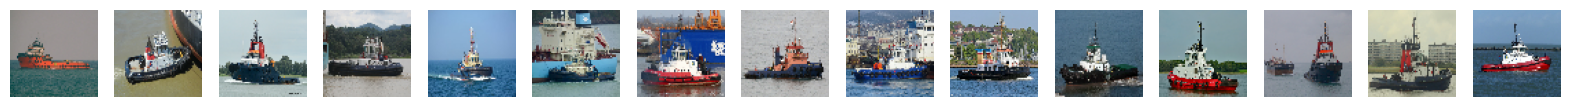

In [3]:
input_dir = str(real_dir + '/' + generating_class)

dataset = keras.utils.image_dataset_from_directory(
    input_dir, label_mode=None, image_size=(64, 64), batch_size=256
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.figure(figsize=(20,15))

    for i in range (15):
        plt.subplot(1, 15, i + 1)
        plt.axis("off")
        plt.imshow((x.numpy() * 255).astype("int32")[i])
    break

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


In [5]:
#encoder
def getEncoder(convLayers=1, denseLayer=1, denseUnits=1024, latent_dim=2, activation='relu', filters=32, kernel=3, addBatchNorm=True, addDropout=True, dropout_rate=0):
  encoder_inputs = keras.Input(shape=(64, 64, 3))

  for i in range(convLayers):
    if i == 0:
      x = layers.Conv2D(filters*(2**i), kernel, activation=activation, strides=2, padding="same")(encoder_inputs)
      if addBatchNorm == True:
          x = layers.BatchNormalization()(x)
      if addDropout == True:
          x = layers.Dropout(dropout_rate)(x)
    else:
      x = layers.Conv2D(filters*(2**i), kernel, activation=activation, strides=2, padding="same")(x)
      if addBatchNorm == True:
          x = layers.BatchNormalization()(x)
      if addDropout == True:
          x = layers.Dropout(dropout_rate)(x)

  x = layers.Flatten()(x)

  for i in range(denseLayer):
    x = layers.Dense(denseUnits//(2**i), activation="relu")(x)
    if addBatchNorm == True:
        x = layers.BatchNormalization()(x)
    if addDropout == True:
        x = layers.Dropout(dropout_rate)(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  return encoder

#decoder
def getDecoder(convLayers=1, denseLayers=3, latent_dim=2, latent_dim_mult=16, activation='relu', filters=32, kernel=3, addBatchNorm=True, addDropout=True, dropout_rate=0):
  latent_inputs = keras.Input(shape=(latent_dim,))

  for i in range(denseLayers):
    if i == 0:
      x = layers.Dense(latent_dim*latent_dim_mult*(2**i), activation=activation)(latent_inputs)
      if addBatchNorm == True:
          x = layers.BatchNormalization()(x)
      if addDropout == True:
          x = layers.Dropout(dropout_rate)(x)
    else:
      x = layers.Dense(latent_dim*latent_dim_mult*(2**i), activation=activation)(x)
      if addBatchNorm == True:
          x = layers.BatchNormalization()(x)
      if addDropout == True:
          x = layers.Dropout(dropout_rate)(x)

  if(denseLayers==0):
    x = latent_inputs

  x = layers.Dense((64//(2**convLayers)) * (64//(2**convLayers)) * filters*(2**(convLayers-1)), activation=activation)(x)
  if addBatchNorm == True:
      x = layers.BatchNormalization()(x)
  if addDropout == True:
      x = layers.Dropout(dropout_rate)(x)

  x = layers.Reshape( ( 64//(2**convLayers), 64//(2**convLayers), filters*(2**(convLayers-1)) )  )   (x)

  for i in range(convLayers):
    x = layers.Conv2DTranspose((convLayers*filters)//(i+1), kernel, activation=activation, strides=2, padding="same")(x)
    if addBatchNorm == True:
        x = layers.BatchNormalization()(x)
    if addDropout == True:
        x = layers.Dropout(dropout_rate)(x)

  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  decoder.summary()
  return decoder

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
# Configurações globais
image_size = 64  # Dimensão para redimensionar imagens
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Função para carregar e pré-processar uma imagem
def load_image(image_path):
    with Image.open(image_path) as img:
        img = img.convert("RGB")
        tensor = transform(img) * 255  # Escalar de [0, 1] para [0, 255]
        return tensor.to(torch.uint8).unsqueeze(0)  # Adiciona dimensão de batch (1, C, H, W)

# Função para calcular FID
def calculate_fid(real_dir, generated_dir, target_class, num_samples=100, batch_size=10):
    real_class_dir = os.path.join(real_dir, target_class)
    generated_class_dir = os.path.join(generated_dir, target_class)

    # Listar imagens nas pastas
    real_files = [os.path.join(real_class_dir, f) for f in os.listdir(real_class_dir) if f.endswith(("png", "jpg", "jpeg"))]
    gen_files = [os.path.join(generated_class_dir, f) for f in os.listdir(generated_class_dir) if f.endswith(("png", "jpg", "jpeg"))]

    if len(real_files) < num_samples or len(gen_files) < num_samples:
        raise ValueError(f"Imagens insuficientes para a classe '{target_class}'. É necessário pelo menos {num_samples} imagens por classe.")

    sampled_real = np.random.choice(real_files, num_samples, replace=False)
    sampled_gen = np.random.choice(gen_files, num_samples, replace=False)

    fid = FrechetInceptionDistance()

    # Usar tqdm para mostrar o progresso
    for i in tqdm(range(0, num_samples, batch_size), desc=f"Processando classe '{target_class}'"):
        batch_real_files = sampled_real[i:i + batch_size]
        batch_gen_files = sampled_gen[i:i + batch_size]

        real_batch = []
        gen_batch = []

        for real_file, gen_file in zip(batch_real_files, batch_gen_files):
            # Preparar imagens para FID
            real_batch.append(load_image(real_file))
            gen_batch.append(load_image(gen_file))

        # Concatenar batches
        real_batch = torch.cat(real_batch, dim=0)
        gen_batch = torch.cat(gen_batch, dim=0)

        # Atualizar FID por batch
        fid.update(real_batch, real=True)
        fid.update(gen_batch, real=False)

    # Calcular FID final
    fid_score = fid.compute()

    return fid_score.item()

In [7]:
best_convLayers = 6
best_denseLayer1 = 1
best_denseUnits = 60
best_activation = 'gelu'
best_filters = 103
best_kernel = 5
best_addBatchNorm = False
best_addDropout = False
best_dropout_rate = 0.08233384817854303
best_denseLayer2 = 0
best_latent_dim = 13
best_latent_dim_mult = 9
best_learning_rate = 2.4790430493940505e-05
best_optimzer = keras.optimizers.Lion(learning_rate=best_learning_rate)
best_batch_size = 128

encoder = getEncoder(convLayers=best_convLayers, denseLayer=best_denseLayer1, denseUnits=best_denseUnits, latent_dim=best_latent_dim, activation=best_activation, filters=best_filters, kernel=best_kernel, addBatchNorm=best_addBatchNorm, addDropout=best_addDropout, dropout_rate=best_dropout_rate)
decoder = getDecoder(convLayers=best_convLayers, denseLayers=best_denseLayer2, latent_dim=best_latent_dim, latent_dim_mult=best_latent_dim_mult, activation=best_activation, filters=best_filters, kernel=best_kernel, addBatchNorm=best_addBatchNorm, addDropout=best_addDropout, dropout_rate=best_dropout_rate)

vae = VAE(encoder, decoder)
vae.compile(optimizer=best_optimzer)
history = vae.fit(dataset, epochs=1000, batch_size=best_batch_size)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      7,828 │ input_layer[0][0] │
│                     │ 103)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │    530,656 │ conv2d[0][0]      │
│                     │ 206)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 412) │  2,122,212 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 824) │  8,488,024 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 2, 2,      │ 33,950,448 │ conv2d_3[0][0]    │
│                     │ 1648)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1,      │ 135,798,4… │ conv2d_4[0][0]    │
│                     │ 3296)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3296)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60)        │    197,820 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 13)        │        793 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 13)        │        793 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 13)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 181,097,070 (690.83 MB)

 Trainable params: 181,097,070 (690.83 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3296)           │        46,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 3296)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 2, 2, 618)      │    50,923,818 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 4, 4, 309)      │     4,774,359 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 8, 8, 206)      │     1,591,556 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 154)    │       793,254 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 123)    │       473,673 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 103)    │       316,828 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 64, 64, 3)      │         2,784 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,922,416 (224.77 MB)

 Trainable params: 58,922,416 (224.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000


2025-07-25 02:58:34.466598: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1629] failed to alloc 1073741824 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2025-07-25 02:58:34.466638: W external/local_xla/xla/stream_executor/integrations/device_host_allocator.h:51] could not allocate pinned host memory of size: 1073741824
I0000 00:00:1753412315.561074    9868 service.cc:145] XLA service 0x7fc8b8015690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753412315.561112    9868 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-07-25 02:58:35.613628: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-25 02:58:35.769246: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2025-07-25 02:58:41.610116: E external/local_xla/xla/

22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - kl_loss: 7.5032e-07 - loss: 2839.0000 - reconstruction_loss: 2839.0000
Epoch 2/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - kl_loss: 3.2405e-04 - loss: 2838.2737 - reconstruction_loss: 2838.2732
Epoch 3/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - kl_loss: 2.6217 - loss: 2832.0867 - reconstruction_loss: 2829.4651
Epoch 4/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - kl_loss: 15.7320 - loss: 2763.4534 - reconstruction_loss: 2747.7214
Epoch 5/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - kl_loss: 6.1886 - loss: 2724.4272 - reconstruction_loss: 2718.2388
Epoch 6/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - kl_loss: 5.9157 - loss: 2705.0159 - reconstruction_loss: 2699.1001
Epoch 7/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - kl_loss: 8.2868 - loss: 2684.0723 - reconstruction_loss: 2675.7852
Epoch 8/1000
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - kl_loss: 8.6446 - loss: 2675.8582 - reconstruction_loss: 2667.2134
Epoch 9/1000
22/22 ━━━━━━━

In [8]:
num_images = 5400
output_dir = str(fake_dir + "/" + generating_class + "/")
os.makedirs(output_dir, exist_ok=True)
filename = str(generating_class + "%d.png")
output_path = os.path.join(output_dir, filename)

keras.random.SeedGenerator(42)

for i in range(num_images):
  # Amostrando pontos no espaço latente
  z_sample = np.random.normal(0, 1, (1, best_latent_dim))  # Amostra aleatória do espaço latente
  generated_image = vae.decoder.predict(z_sample, verbose=0)[0]  # Decodifica o ponto amostrado

  # Normalizando a imagem para o intervalo [0, 255] antes de salvar
  generated_image = (generated_image * 255).astype(np.uint8)

  # Salvar a imagem em uma pasta
  plt.imsave(output_path % (i), generated_image)

# Métrica FID para avaliar a qualidade do modelo
fid_score = calculate_fid(real_dir, fake_dir, generating_class, num_samples=num_images)

print(f"FID = {fid_score}")

Processando classe 'TUG': 100%|███████████████████████████████████████████████████████| 540/540 [04:22<00:00,  2.06it/s]


FID = 41.7757568359375
